# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Сравнение алгоритмов классификации


**План:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.0
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
pandas 0.23.4
matplotlib 2.2.3
statsmodels 0.9.0
sklearn 0.19.2

compiler   : MSC v.1912 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# путь к данным
PATH_TO_DATA = 'C:\\Users\\wild-moray\\Desktop\\ML\\final\\pkls'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [3]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [4]:
X_sparse_10users=X_sparse_10users.toarray()[:,1:]

In [16]:
y_10users

array(['31', '31', '31', ..., '241', '241', '241'], dtype=object)

In [4]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [6]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [16]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучим `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрим на долю правильных ответов на 3-кратной кросс-валидации по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [49]:
knn = KNeighborsClassifier(n_neighbors=100,n_jobs=-1)

In [50]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [51]:
pred=knn.predict(X_valid)

In [52]:
round(accuracy_score(pred,y_valid),3)

0.58

In [68]:
cross_val=cross_val_score(X=X_train,y=y_train,cv=skf,estimator=knn,scoring='accuracy')

In [69]:
round(cross_val.mean(),3)

0.557

In [57]:
a=[round(i,3) for i in cross_val]

In [60]:
np.mean(a)

0.505

**2. Обучим случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрим на OOB-оценку и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания `n_jobs`=-1.**

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
forest = RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=17,oob_score=True)

In [63]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=17, verbose=0, warm_start=False)

In [64]:
pred_forest=forest.predict(X_valid)

In [66]:
forest.oob_score_

0.7214996951839057

In [73]:
round(accuracy_score(y_valid,pred_forest),3)

0.725

In [70]:
cross_val_forest=cross_val_score(X=X_train,y=y_train,cv=skf,estimator=forest,scoring='accuracy')

In [72]:
round(cross_val_forest.mean(),3)

0.713

In [ ]:
!cat answer4_2.txt

**3. Обучим логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`. Для распараллеливания `n_jobs=-1`.**

In [7]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [75]:
logit = LogisticRegression(n_jobs=-1,random_state=17)

In [76]:
logit.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
round(accuracy_score(y_valid,logit.predict(X_valid)),3)

0.776

In [78]:
round(cross_val_score(X=X_train,y=y_train,cv=skf,estimator=logit,scoring='accuracy').mean(),3)

0.769

**С помощью `LogisticRegressionCV` подберем параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2

In [8]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10) 

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1,multi_class='multinomial',cv=skf,random_state=17,n_jobs=-1,
                                            scoring='accuracy')
logit_grid_searcher1.fit(X_train, y_train)

Wall time: 2min 18s


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [10]:
scores=logit_grid_searcher1.scores_

In [11]:
def mean_scor(scores,n):
    mean_scores=[]
    for i in range(0,n):
        temp=[]
        for key in scores.keys():
            for j in range(len(scores[key])):
                temp.append(scores[key][j][i])
        mean_scores.append(np.mean(temp))
    return mean_scores

In [12]:
mean_scores=mean_scor(scores,3)

In [13]:
logit_grid_searcher1.Cs_

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [14]:
dict(zip(logit_grid_searcher1.Cs_,mean_scores))

{0.0001: 0.30847502708115615,
 0.00046415888336127773: 0.4722647748401496,
 0.002154434690031882: 0.553955189639828}

In [19]:
logit_grid_searcher1.scores_

{'100': array([[0.30624049, 0.46757991, 0.5500761 , 0.64748858, 0.71902588,
         0.75342466, 0.76651446, 0.76073059, 0.75342466, 0.74581431],
        [0.31290027, 0.47514486, 0.55413236, 0.65599268, 0.71729186,
         0.75083867, 0.76303751, 0.7621226 , 0.75846295, 0.7462641 ],
        [0.30628432, 0.47406955, 0.55765711, 0.65863331, 0.7266626 ,
         0.76662599, 0.77120195, 0.77425259, 0.76723612, 0.75442343]]),
 '127': array([[0.30624049, 0.46757991, 0.5500761 , 0.64748858, 0.71902588,
         0.75342466, 0.76651446, 0.76073059, 0.75342466, 0.74581431],
        [0.31290027, 0.47514486, 0.55413236, 0.65599268, 0.71729186,
         0.75083867, 0.76303751, 0.7621226 , 0.75846295, 0.7462641 ],
        [0.30628432, 0.47406955, 0.55765711, 0.65863331, 0.7266626 ,
         0.76662599, 0.77120195, 0.77425259, 0.76723612, 0.75442343]]),
 '128': array([[0.30624049, 0.46757991, 0.5500761 , 0.64748858, 0.71902588,
         0.75342466, 0.76651446, 0.76073059, 0.75342466, 0.74581431],
  

Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20)

In [20]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2,multi_class='multinomial',cv=skf,random_state=17,n_jobs=-1,
                                            scoring='accuracy')
logit_grid_searcher2.fit(X_train, y_train)

Wall time: 6min 5s


In [21]:
scores2=logit_grid_searcher2.scores_

In [26]:
c_=logit_grid_searcher2.Cs_[10]

In [55]:
mean_scores2=mean_scor(scores2,20)

In [267]:
mean_scores2

[0.7420280325448577,
 0.7655972070951058,
 0.766816008168599,
 0.7676288928927998,
 0.7657999326804995,
 0.766918438889361,
 0.7673253146250677,
 0.7673258410343746,
 0.7671228983656787,
 0.7671227437026763,
 0.7670211177053257,
 0.76692051311819,
 0.7658045451271644,
 0.7653977004033582,
 0.7656005500363535,
 0.7653970503429491,
 0.7645840105592465,
 0.7646854198697942,
 0.7645843198852517,
 0.7644821984904941]

In [56]:
ces=list(zip(mean_scores2,logit_grid_searcher2.Cs_))

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [58]:
c_best=sorted(ces)[-1][1]
c_best

1.1894736842105265

In [71]:
c_best_best=logit_grid_searcher2.Cs_[9]
c_best_best

3.368421052631579

In [287]:
sorted(ces)[-1]

(0.7676288928927998, 1.1894736842105265)

In [ ]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [279]:
logit_best = LogisticRegression(n_jobs=-1,random_state=17,C=c_best)

In [280]:
logit_best.fit(X_train,y_train)

LogisticRegression(C=1.1894736842105265, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [285]:
cross_val_lbest=cross_val_score(X=X_train,y=y_train,cv=skf,estimator=logit_best,scoring='accuracy')

In [290]:
round(cross_val_lbest.mean(),3)

0.769

In [288]:
logit_cv_acc = accuracy_score(y_valid,logit_best.predict(X_valid))

In [291]:
round(logit_cv_acc,3)

0.778

**4. Обучим линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрим на долю правильных ответов на кросс-валидации и на выборке `(X_valid, y_valid)`.**

In [292]:
from sklearn.svm import LinearSVC

In [293]:
svm = LinearSVC(C=1,random_state=17)

In [294]:
svm.fit(X_train,y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0)

In [295]:
cross_val_svm=cross_val_score(X=X_train,y=y_train,cv=skf,estimator=svm,scoring='accuracy')

In [297]:
cross_val_svm.mean()

0.7600132496942211

In [296]:
accuracy_score(y_valid,svm.predict(X_valid))

0.7774354112348898

**С помощью `GridSearchCV` подберем параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4. Нарисуем кривые валидации.**

In [299]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(estimator=svm,param_grid=svm_params1,cv=skf,n_jobs=-1,scoring='accuracy')
svm_grid_searcher1.fit(X_train, y_train)

Wall time: 45.6 s


лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [301]:
svm_grid_searcher1.best_score_

0.6923389554968502

In [305]:
svm_grid_searcher1.best_params_

{'C': 2222.2223000000004}

график зависимости доли правильных ответов на кросс-валидации от `C`.

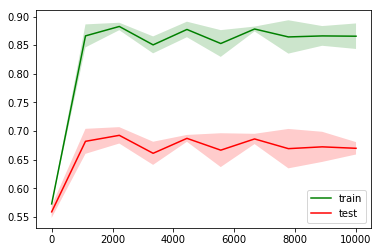

In [306]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)


**С помощью `GridSearchCV` подберем параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений. Нарисуем кривые валидации.**

In [307]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(estimator=svm,param_grid=svm_params2,cv=skf,n_jobs=-1,scoring='accuracy')
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 38s


Лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [308]:
print(svm_grid_searcher2.best_score_,svm_grid_searcher2.best_params_)

0.7711847185531396 {'C': 0.13879310344827586}


График зависимости доли правильных ответов на кросс-валидации от С.

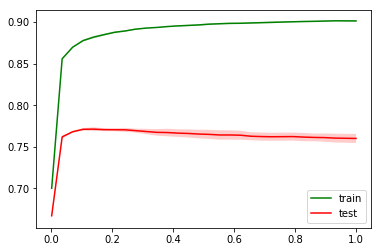

In [309]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [316]:
best_c=svm_grid_searcher2.best_params_['C']

In [318]:
svm_best=LinearSVC(C=best_c,random_state=17)

In [319]:
svm_best.fit(X_train,y_train)

LinearSVC(C=0.13879310344827586, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=17,
     tol=0.0001, verbose=0)

In [321]:
svm_cv_acc = accuracy_score(y_valid,svm_best.predict(X_valid))

In [323]:
round(svm_cv_acc,3)

0.782

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определим функцию `model_assessment`, ее документация описана ниже. 

In [327]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_sparse = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y = pickle.load(y_pkl)
    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=test_size, 
                                                     random_state=random_state, stratify=y)
    mean_accuracy_train=cross_val_score(X=X_train,y=y_train,cv=cv,estimator=estimator,scoring='accuracy').mean()
    estimator.fit(X_train,y_train)
    accuracy_valid=accuracy_score(y_valid,estimator.predict(X_valid))
    return mean_accuracy_train,accuracy_valid
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    

**Убедимся, что функция работает.**

In [328]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

(0.7711850628759495, 0.7821758710594928)

In [335]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_10users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
        print(session_length,window_size,
              model_assessment(estimator,path_to_X_pkl,path_to_y_pkl,skf,random_state=17,test_size=0.3))

15 10 (0.8217896546706148, 0.8400094809196492)
10 10 (0.7711850628759495, 0.7821758710594928)
15 7 (0.8470874683536852, 0.8544881367181019)
10 7 (0.7975853695418165, 0.8075327692052431)
7 7 (0.7544123057721982, 0.7629002820640451)
15 5 (0.8689670755674888, 0.8764817449027975)
10 5 (0.8179570941042811, 0.8253911806543386)
7 5 (0.7753290851849481, 0.7871028923660502)
5 5 (0.7267058295650503, 0.7367235656709341)
Wall time: 35.4 s


In [337]:
print(round(0.8689670755674888,3),round(0.8764817449027975,3))

0.869 0.876


In [338]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = os.path.join(PATH_TO_DATA, 'X_sparse_150users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
    path_to_y_pkl = os.path.join(PATH_TO_DATA, 'y_150users_s'+str(session_length)+'_w'+str(window_size)+'.pkl')
    print(session_length,window_size, 
              model_assessment(estimator,path_to_X_pkl,path_to_y_pkl,skf,random_state=17,test_size=0.3))

5 5 (0.409666167729474, 0.42267727648805176)
7 7 (0.43686797191901516, 0.45415062847021154)
10 10 (0.4633351827852912, 0.4833600934170194)
Wall time: 22min 59s


In [339]:
print(round(0.4633351827852912,3),round(0.4833600934170194,3))

0.463 0.483


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [27]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [28]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучим `LogisticRegressionCV` для одного значения параметра `C`. Теперь будем решать 150 задач "Один-против-Всех", поэтому аргумент `multi_class`='ovr'.**

In [72]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[c_best_best],multi_class='ovr',cv=skf,random_state=17,n_jobs=-1,
                                            scoring='accuracy')
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 6min 13s


In [73]:
logit_cv_150users.scores_['100'].mean()

0.9944844753392146

**Посмотрим на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [62]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    cv_scores_by_user[user_id]=logit_cv_150users.scores_[user_id].mean()
    print('User {}, CV score: {}'.format(user_id,logit_cv_150users.scores_[user_id].mean()))

User 100, CV score: 0.9946721646157268
User 1014, CV score: 0.9971119218290033
User 102, CV score: 0.991304590725278
User 103, CV score: 0.98072223382175
User 1040, CV score: 0.9969242988909531
User 105, CV score: 0.9968095234529253
User 1054, CV score: 0.9967052416254596
User 106, CV score: 0.9946092310445188
User 118, CV score: 0.9908145970292673
User 119, CV score: 0.9967681180642449
User 120, CV score: 0.9943905791196491
User 1248, CV score: 0.9978523640316102
User 126, CV score: 0.9950890652920861
User 1267, CV score: 0.997466351407201
User 127, CV score: 0.9917011158463745
User 128, CV score: 0.9848093702222966
User 1299, CV score: 0.9969869167121207
User 13, CV score: 0.9963925985763509
User 1371, CV score: 0.9935669977656993
User 138, CV score: 0.9971642581529835
User 15, CV score: 0.9951729812443751
User 158, CV score: 0.9972267016330273
User 16, CV score: 0.9920968524906767
User 160, CV score: 0.9967263746214964
User 165, CV score: 0.9973518529988693
User 172, CV score: 0.996

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом.**

In [375]:
class_distr = np.bincount(y_train_150.astype('int'))
len(class_distr)

2903

In [74]:
len(y_train_150[y_train_150!='103'])/len(y_train_150)

0.9769999895738847

In [75]:
class_distr = np.bincount(y_train_150.astype('int'))
users_def=[]

for user_id in np.unique(y_train_150):
    t=len(y_train_150[y_train_150!=user_id])/len(y_train_150)
    users_def.append(np.mean(logit_cv_150users.scores_[user_id])-t)

In [76]:
users_def=np.array(users_def)
len(users_def[users_def>0])

118

In [81]:
round(122/150,3)

0.813

In [69]:
1-118/150

0.21333333333333337

In [49]:
logit_cv_150users.scores_['100'].mean()

0.9945053448775908

In [50]:
np.mean(logit_cv_150users.scores_['100'])

0.9945053448775908